<a href="https://colab.research.google.com/github/fintechsteve/modeling-volatility/blob/master/Part_03_Modeling_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 03: Building a Modeling Framework

### In this section you will:


*   Understand the importance of creating holdback samples
*   Explore some of the challenges of setting up a performance metric for data science models in a backtesting framework.
*   Create a generalized function that can be used to provide in- and out-of-sample performance metrics


## Import all necessary libraries

For this piece, we will need the following packages to be available to our environment:

*   Numpy and Pandas (For data manipulation)
*   DateTime (For basic date manipulation)
*   Matplotlib (For timeseries vizualization)

If the packages are not available, install the with "pip install X"

In [0]:
import numpy as np, pandas as pd
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt


### Read in data from previously stored returns.pkl file



In [2]:
with open('./returns.pkl', 'rb') as f:
    returns = pickle.load(f)
    f.close()
returns.head(10)

,AUD,CAD,CHF,EUR,GBP,JPY,NOK,NZD,SEK
1975-01-02,-0.002129,-1.712061e-03,-0.009915,-0.003544,-0.005745,-0.001502,-0.003299,0.000536,-0.004704
1975-01-03,-0.000947,1.517425e-05,0.008500,0.007886,0.003424,0.002711,0.008801,-0.001924,0.007113
1975-01-06,-0.001158,6.677374e-04,-0.001023,0.008174,0.002346,-0.004728,0.002759,-0.001129,0.009237
1975-01-07,0.004193,-1.726304e-03,0.001702,0.002150,0.001702,0.002410,0.005434,0.004567,-0.001466
1975-01-08,-0.001489,-2.000930e-04,-0.015237,-0.008650,-0.001997,0.000122,-0.006315,-0.000034,-0.006188
1975-01-09,-0.000324,-3.120108e-03,0.000298,0.004764,0.000298,-0.000409,-0.000114,-0.001217,-0.000751
1975-01-10,0.000077,-1.283429e-03,0.001489,0.001489,0.001489,0.000075,0.006256,0.000311,0.001489
1975-01-13,0.000579,-3.152212e-07,0.001789,-0.001210,0.000127,-0.000578,0.000542,0.000969,-0.002488
1975-01-14,-0.000699,7.303998e-04,-0.005132,-0.006698,-0.001827,0.000291,-0.006558,-0.000762,-0.007795
1975-01-15,-0.000934,1.198868e-03,-0.002078,0.001797,-0.000426,-0.002542,-0.002276,-0.000594,0.000094


### The importance of creating a holdback sample

When conducting data science around model building, it is important to understand the role that time plays in your modeling.

All estimation must be done using historical data. Inferences that arise from "forward looking" data can bias our understanding and the model decision making process, so it is important that we exclude them from calculations.

Unfortunately, we are not always clear about the ways in which "forward looking" can enter our modeling process and some disciplines are notoriously lax in their approach. The following "forward looking" data should be carefully controlled:

1.   Back-casting signals and model weights over the period used for estimation (in-sample). While the performance in this sample can be a useful gut check, it is dangerous to place too much weight on these insights.

2.   Data alignment and computational lag. If you run a model using data that goes through 5pm ET on a particular day, you probably can't implement a signal based on this until close of business the following day. If the data takes longer to reach your system (e.g. arrives with a 1 day processing lag) your effective lag may be longer. Performance between the date the model data is labeled and the earliest date a trade could be implemented should not be included in out-of-sample performance.

3.   Data used for macro-parameter or hyper-parameter settings. This is where most financial data scientists get themselves into trouble. If you change the parameters for an estimation window or maximum number of lags in a model using some kind of objective critereon (be it error related, e.g. RMSE, AIC or performance related, e.g. mean return, sharpe ratio, information ratio), you cannot truly count the performance over the period used to make this decision as in-sample.

   This becomes particularly problematic if you use the entire sample to reparameterize your model (e.g. because you found that the original parameterization did not work).



## Best practice for backtesting

Proper discipline around backtesting is critical and difficult to do right. At a minimum you should:

* Create a holdback period and only look at performance during this period once you are confident you have finished changing parameters on your model.
* Determine the method of evaluating your model and what you will do if your out-of-sample performance fails to meet the in-sample performance.
* Parameterize your model using a subset of the non holdback period of data. Ideally use cross-validation methods to minimize overfitting.

Ideally you should also test your model on different out of sample periods, subsamples of securities, etc to determine the robustness of your solution. However, there is an art to doing this in such a way that your testing does not influence or induce further model tweaking.

## Creating a generic model and testing framework

To help us understand our testing framework, lets create a generic model and a separate function that allows us to evaluate the performance of a model.

We can think of a model as a function that takes in a set of input data, a set of parameters and produces a set of model weights.

In the case of this example, the model weights represent be the fraction of exposure we maintain to the DXY basket (vs simply remaining hedged in our base USD currency).

Input data are the currency returns matrix. And finally parameters include:

1) Model parameters such as lookback windows for averaging, lag structure for timeseries estimators (such as maximum number of lags on AR and MA processes).
2) Hyperparameters, such as the window over which parameter estimation vs cross-validation is done, parameters for turning signals into weights, etc.
3) Modeling framework parameters, such as the extent of the holdback parameter and any framework driven constraints on the output (e.g. rescaling out of sample weights to be forced to be uniformly distributed ex post).


## A random model with a fixed seed

To test our framework, let's create a model that generates random weights regardless of the input data and parameters.

We will make the requirement that weights in-sample are uniformly distributed over [0,1] from a modeling framework perspective. However, it is easier (and better) to trust the model to do this, given our parameters.

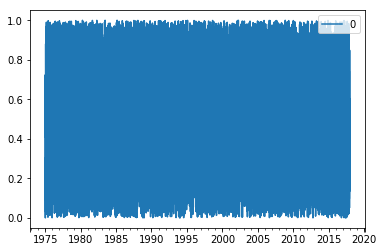

In [30]:
rets = returns
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '2000-01-01'}
model_params = {'seed': 1}
np.random.seed(seed=model_params['seed'])
randwts = pd.DataFrame(np.random.rand(rets['AUD'].count(),1), index=rets.index)
randwts_insample = randwts[framework_params['insample_start_date']:framework_params['insample_end_date']]
randwts_insample = randwts_insample.rank()/randwts_insample.count()
randwts[framework_params['insample_start_date']:framework_params['insample_end_date']] = randwts_insample
randwts.plot()

In [0]:
def random_model(rets, model_params, framework_params):
  np.random.seed(seed=model_params['seed'])
  randwts = pd.DataFrame(np.random.rand(rets['AUD'].count(),1), index=rets.index)
  randwts_insample = randwts[framework_params['insample_start_date']:framework_params['insample_end_date']]
  randwts_insample = randwts_insample.rank()/randwts_insample.count()
  randwts[framework_params['insample_start_date']:framework_params['insample_end_date']] = randwts_insample
  return randwts


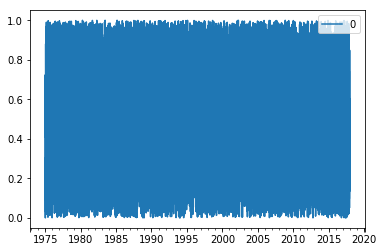

In [32]:
framework_params = {'insample_start_date': '1975-01-02',
                    'insample_end_date': '2000-01-01'}
model_params = {'seed': 1}
randwts = random_model(returns, model_params, framework_params)
randwts.plot()

### Create an evaluation function that calculates the relationship between weight and subsequent DXY index volatility

The measure we are interested in is the subsequent volatility of the dxy index. For the sake of argument, we will simply use squared returns to proxy volatility (Generally currencies shouldn't have a trend if implemented using forwards to avoid interest rate differentials).

Start by calculating the dxy index again:

In [34]:
dxy_weight = [0, 0.119, 0.036, 0, 0.136, 0.576, 0, 0, 0.091]
dxy = returns.dot(dxy_weight)
dxy.head(10)


1975-01-02   -0.002635
1975-01-03    0.002982
1975-01-06   -0.001521
1975-01-07    0.001342
1975-01-08   -0.001337
1975-01-09   -0.000624
1975-01-10    0.000282
1975-01-13   -0.000478
1975-01-14   -0.000888
1975-01-15   -0.001446
dtype: float64

Now create forward looking squared returns

In [1]:
dxy_forward = dxy.shift(-1)
dxy_forward_sq = dxy_forward**2
dxy_forward_sq.head(10)


NameError: ignored

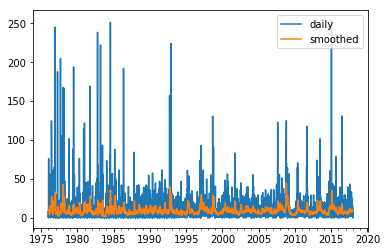

### Convert rolling turbulence into a weight (And do so in a function)

Turbulence as a raw statistic ranges between 0 and infinity. It cannot be directly used for investment strategies without some kind of transformation into model weights.

Our most obvious optiions are to create a binary cutoff or linear ranking. We are going to use linear ranking, though there are reasons why you might want to use a binary cutoff (simple on/off model).

The linear ranking, when used in-sample, should map results to a uniform distribution.

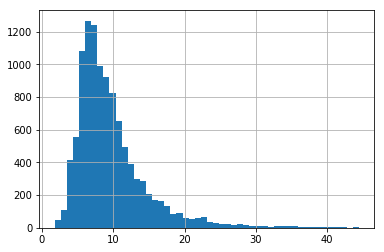

In [0]:
roll_turb['smoothed'].hist(bins=50)

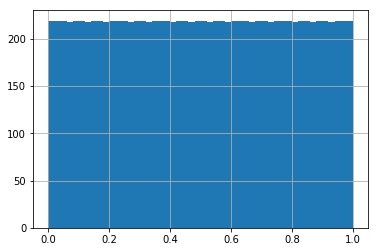

In [0]:
historical_turb_rank = roll_turb['smoothed'].dropna().rank()/roll_turb['smoothed'].count()
historical_turb_rank.hist(bins=50)


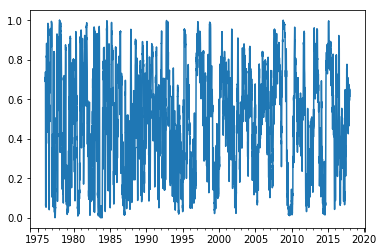

In [0]:
insample_start_date = '1975-01-02'
insample_end_date = '2000-01-01'
insample_turb = (roll_turb['smoothed'].loc[insample_start_date:insample_end_date]).dropna().values
insample_turb.sort()
num_insample = np.size(insample_turb)
roll_turb['ranked'] = np.true_divide(list(map(lambda x:float('NaN') if np.isnan(x) else bisect.bisect_left(insample_turb,x), roll_turb['smoothed'])),num_insample)
roll_turb['ranked'].plot()

In [0]:
def turbulence_weights(roll_turb, insample_start_date, insample_end_date):
  insample_turb = (roll_turb['smoothed'].loc[insample_start_date:insample_end_date]).dropna().values
  insample_turb.sort()
  num_insample = np.size(insample_turb)
  turb_weights = pd.DataFrame(np.true_divide(list(map(lambda x:float('NaN') if np.isnan(x) else bisect.bisect_left(insample_turb,x), roll_turb['smoothed'])),num_insample), index=roll_turb.index)
  turb_weights.columns=['weights']
  return turb_weights

In [0]:
turb_weights = turbulence_weights(roll_turb, '1975-01-02', '2000-01-01')
turb_weights.tail(20)

,weights
2017-11-29,0.504805
2017-11-30,0.510730
2017-12-01,0.543722
2017-12-04,0.536355
2017-12-05,0.547406
2017-12-06,0.593530
2017-12-07,0.600897
2017-12-08,0.608424
2017-12-11,0.647822
2017-12-12,0.604901


### Demonstrate that contemporaneously turbulence is concurrrent with high index volatility



In [0]:
dxy_weight = [0, 0.119, 0.036, 0, 0.136, 0.576, 0, 0, 0.091]
dxy = returns.dot(dxy_weight)

In [0]:
highturbulence = turbulence['daily']>np.percentile(turbulence['daily'],80)
pd.DataFrame([[np.sqrt(261)*dxy[highturbulence].std(), np.sqrt(261)*dxy[~highturbulence].std()], [sum(highturbulence), sum(~highturbulence)]], index=['std','N'], columns=['High Turb','Low Turb'])

,High Turb,Low Turb
std,0.122616,0.057833
N,2243.000000,8971.000000


### Demonstrate that turbulence leads to persistently high volatility days

In [0]:
leading_dxy = pd.DataFrame([dxy.shift(-i) for i in range(0, 11)]).T
subsequent_vol = pd.DataFrame([leading_dxy[highturbulence].std(), leading_dxy[~highturbulence].std()],index=['High Turb','Low Turb']).T
subsequent_vol

,High Turb,Low Turb
0,0.007590,0.003580
1,0.005493,0.004446
2,0.005453,0.004458
3,0.005319,0.004499
4,0.005441,0.004461
5,0.005424,0.004467
6,0.005321,0.004499
7,0.005109,0.004560
8,0.005221,0.004529
9,0.005095,0.004565


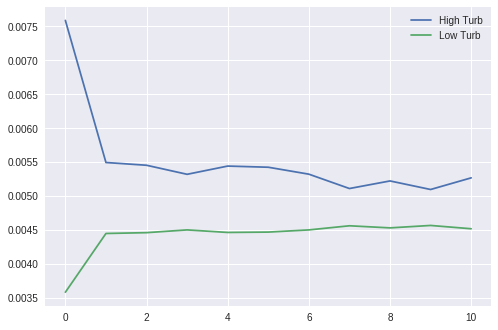

In [0]:
subsequent_vol.plot()